<a href="https://colab.research.google.com/github/onebom/NowMSM_AI/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [1]:
%tensorflow_version 2.x
# TPU 사용
import tensorflow as tf
# import os

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# strategy = tf.distribute.TPUStrategy(resolver)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import collections

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

# **Load data**

In [ ]:
# dataset is saved in my google drive
%cp -av "/content/gdrive/MyDrive/loopQ/project" "/content"
%cd /content/project/

In [5]:
def load_data(data_file):
    print('Loading data ...')
    with open(data_file, 'rb') as f:
        pickle_data = pickle.load(f)
        x_data = pickle_data['x_data']
        y_data = pickle_data['y_data']
    print('Data loaded.')
    return x_data, y_data

In [6]:
data_file = './gdrive/MyDrive/NowMSM/train_data.p'
images, labels = load_data(data_file)

n_samples = labels.shape[0]
print('Total samples:', n_samples)
print('images shape:', images.shape)
print('labels shape:', labels.shape)

Loading data ...
Data loaded.
Total samples: 28794
images shape: (28794, 48, 48)
labels shape: (28794,)


In [7]:
print(labels)

['angry' 'angry' 'angry' ... 'surprise' 'surprise' 'surprise']


# label preprocessing

In [8]:
for idx,l_kind in enumerate(labels):
  if l_kind == "angry":
    labels[idx]=0
  elif l_kind == "disgust":
    labels[idx]=1
  elif l_kind == "fear":
    labels[idx]=2
  elif l_kind == "happy":
    labels[idx]=3
  elif l_kind == "neutral":
    labels[idx]=4
  elif l_kind == "sad":
    labels[idx]=5
  elif l_kind == "surprise":
    labels[idx]=6

labels=labels.astype(int)
print(labels)
print(np.unique(labels))



[0 0 0 ... 6 6 6]
[0 1 2 3 4 5 6]


# **Explore data**

In [9]:
emotions = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

num_classes = len(emotions)

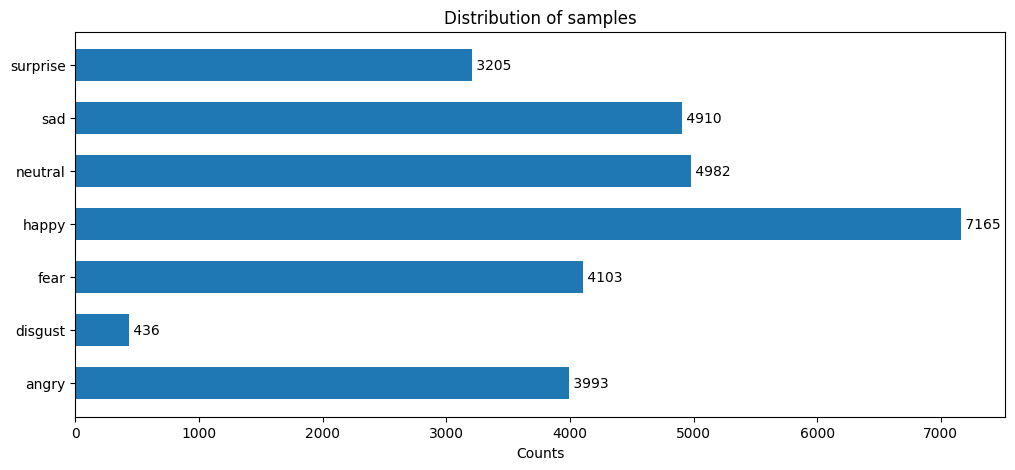

In [10]:
def plot_sample_distribution(labels):
    classes, cnts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(12, 5))
    plt.barh(list(emotions.values()), cnts, height=0.6)
    for i, v in enumerate(cnts):
        plt.text(v, i, ' '+str(v), va='center')
    plt.xlabel('Counts')
    plt.title("Distribution of samples")

plot_sample_distribution(labels)

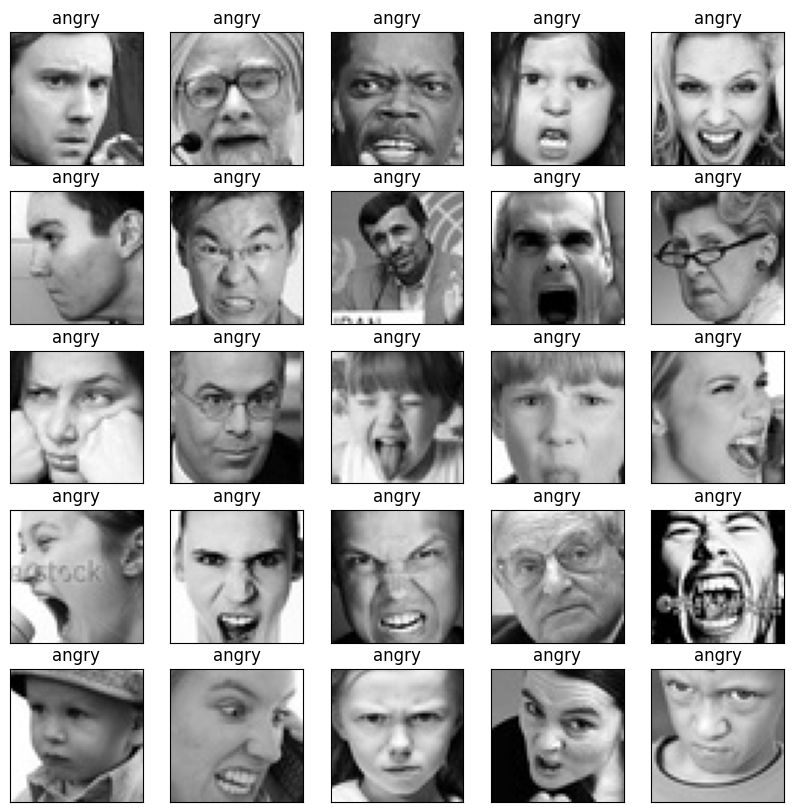

In [11]:
def show_images(images, labels, col=5):
    n = images.shape[0]
    row = int(np.ceil(n / col))
    fig = plt.figure(figsize=(2*col, 2*row))
    for i in range(n):
        fig.add_subplot(row, col, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(emotions[labels[i]])
        plt.xticks([]), plt.yticks([])
    plt.show()

show_images(images[:25], labels[:25])

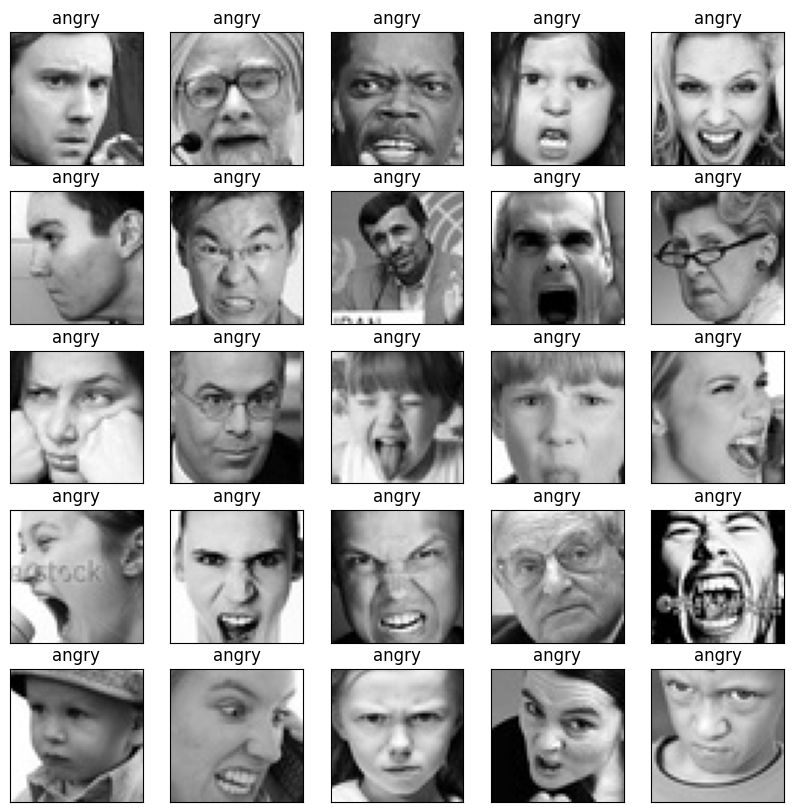

In [12]:
def show_one_emotion(images, labels, id, start=0, num=25):
    image_x = images[labels==id]
    label_x = labels[labels==id]
    show_images(image_x[start:start+num], label_x[start:start+num])

show_one_emotion(images, labels, id=0)

# **Split dataset**

In [13]:
image_train, image_test, label_train, label_test = train_test_split(images, labels, test_size=0.2, random_state=42)
image_train, image_val, label_train, label_val = train_test_split(image_train, label_train, test_size=0.2, random_state=42)

print('Training samples:', label_train.shape[0])
print('Validation samples:', label_val.shape[0])
print('Test samples:', label_test.shape[0])

Training samples: 18428
Validation samples: 4607
Test samples: 5759


# **Upsamling training data**

In [14]:
def upsampling(x, y, strategy):
    (n, w, h) = x.shape
    sm = SMOTE(sampling_strategy=strategy, random_state=42)
    x_flat = x.reshape((n,-1))
    x_up, y_up = sm.fit_resample(x_flat, y)
    n_up = x_up.shape[0]
    x_up = x_up.reshape((n_up,w,h))

    return x_up, y_up

In [15]:
collections.Counter(label_train)

Counter({4: 3214, 2: 2625, 3: 4561, 0: 2567, 6: 2066, 5: 3129, 1: 266})

In [16]:
image_train_up, label_train_up = upsampling(image_train, label_train, 'auto')

In [17]:
collections.Counter(label_train_up)

Counter({4: 4561, 2: 4561, 3: 4561, 0: 4561, 6: 4561, 5: 4561, 1: 4561})

In [18]:
num_classes

7

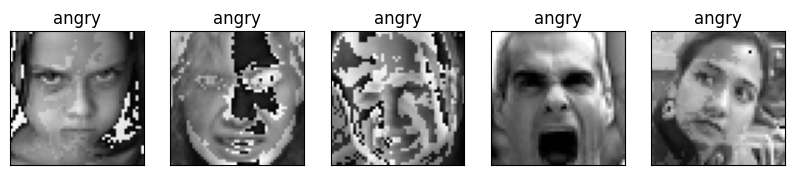

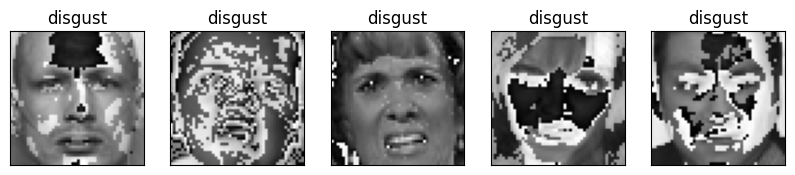

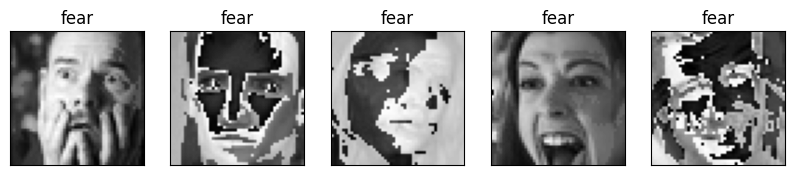

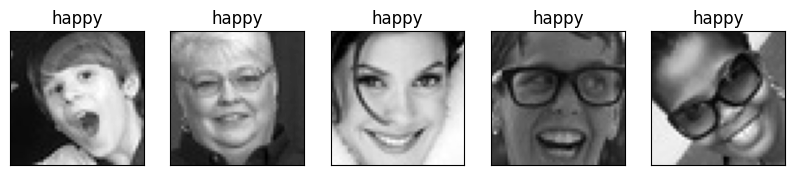

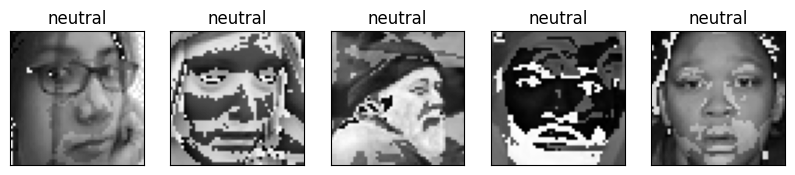

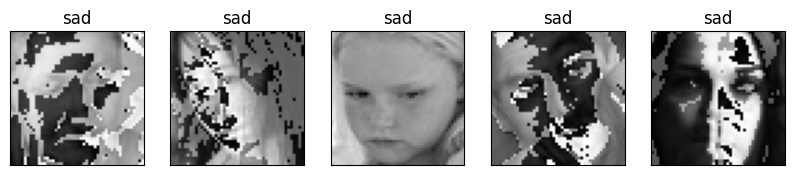

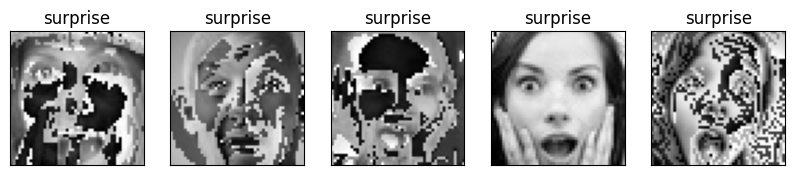

In [19]:
for i in range(num_classes):
    show_one_emotion(image_train_up, label_train_up, id=i, start=4000, num=5)

# **Utils**

In [20]:
def one_hot_encoding(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes)

In [21]:
def reshape_images(images, channel=1, resize=None):
    x = tf.expand_dims(tf.convert_to_tensor(images), axis=3)
    if channel > 1:
        x = tf.repeat(x, channel, axis=3)
    if resize is not None:
        x = tf.image.resize(x, resize)
    return x

In [22]:
def pre_processing(images, labels, num_classes, channel=1, resize=None, one_hot=True):
    x = reshape_images(images, channel, resize)
    y = one_hot_encoding(labels, num_classes)
    return x, y

In [23]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(15, 6))
    plt.rc('font', size=12)
    for n, metric in enumerate(metrics):
        name = metric.capitalize()
        plt.subplot(1,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Training', lw=3, color='navy')
        plt.plot(history.epoch, history.history['val_'+metric], lw=3, label='Validation', color='deeppink')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title('Model '+name)
        plt.legend()
    plt.show()

In [24]:
def evaluate_class(model, x_test, y_test):
    labels = np.argmax(y_test, axis=1)
    print('{:<15}Accuracy'.format('Emotion'))
    print('-'*23)
    for i in range(num_classes):
        x = x_test[labels==i]
        y = y_test[labels==i]
        loss, acc = model.evaluate(x,  y, verbose=0)
        print('{:<15}{:.1%}'.format(emotions[i], acc))
    print('-'*23)
    loss, acc = model.evaluate(x_test,  y_test, verbose=0)
    print('{:<15}{:.1%}'.format('Overall', acc))

# **Model**

In [25]:
def model_checkpoint_cb(file_path):
    return ModelCheckpoint(
        file_path, monitor='val_accuracy', mode='max',
        save_best_only=True, save_weights_only=True)

In [26]:
x_train, y_train = pre_processing(image_train_up, label_train_up, num_classes)
x_val, y_val = pre_processing(image_val, label_val, num_classes)
x_test, y_test = pre_processing(image_test, label_test, num_classes)

train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator()

batch_size = 128
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val)

steps_per_epoch = train_generator.n // train_generator.batch_size
input_shape = x_train[0].shape

In [ ]:
# one_batch = train_generator.next()
# one_batch_images = one_batch[0].reshape((128,48,48))
# one_batch_labels = np.argmax(one_batch[1], axis=1)
# show_images(one_batch_images[:25], one_batch_labels[:25])

In [27]:
class VGGNet(Sequential):
    def __init__(self, input_shape, num_classes, checkpoint_path):
        super().__init__()
        self.add(Rescaling(1./255, input_shape=input_shape))
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
        self.add(BatchNormalization())
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.5))

        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.4))

        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.5))

        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.4))

        self.add(Flatten())
        
        self.add(Dense(1024, activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(256, activation='relu'))

        self.add(Dense(num_classes, activation='softmax'))
        
        self.checkpoint_path = checkpoint_path

In [28]:
# with strategy.scope():
#   model = VGGNet(input_shape, num_classes, 'run/vggnet_up.h5')
#   model.compile(optimizer=Adam(learning_rate=1e-3),
#                     loss=categorical_crossentropy,
#                     metrics=['accuracy'])
# model.summary()

model = VGGNet(input_shape, num_classes, 'run/vggnet_up.h5')
model.compile(optimizer=Adam(learning_rate=1e-3),
                    loss=categorical_crossentropy,
                    metrics=['accuracy'])
model.summary()

Model: "vgg_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0   

In [29]:
epochs = 100

cp = model_checkpoint_cb(model.checkpoint_path)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-10)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

history=model.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=val_generator,
          callbacks=[lr, es, cp])

Epoch 1/100
249/249 [==============================] - 50s 120ms/step - loss: 2.0526 - accuracy: 0.1898 - val_loss: 1.8725 - val_accuracy: 0.2474 - lr: 0.0010
Epoch 2/100
249/249 [==============================] - 28s 114ms/step - loss: 1.8534 - accuracy: 0.2305 - val_loss: 1.8443 - val_accuracy: 0.2520 - lr: 0.0010
Epoch 3/100
249/249 [==============================] - 28s 113ms/step - loss: 1.8244 - accuracy: 0.2511 - val_loss: 1.8024 - val_accuracy: 0.2750 - lr: 0.0010
Epoch 4/100
249/249 [==============================] - 29s 116ms/step - loss: 1.7730 - accuracy: 0.2818 - val_loss: 1.7582 - val_accuracy: 0.2989 - lr: 0.0010
Epoch 5/100
249/249 [==============================] - 28s 112ms/step - loss: 1.7001 - accuracy: 0.3242 - val_loss: 1.5635 - val_accuracy: 0.3746 - lr: 0.0010
Epoch 6/100
249/249 [==============================] - 28s 112ms/step - loss: 1.6215 - accuracy: 0.3624 - val_loss: 1.4594 - val_accuracy: 0.4443 - lr: 0.0010
Epoch 7/100
249/249 [=========================

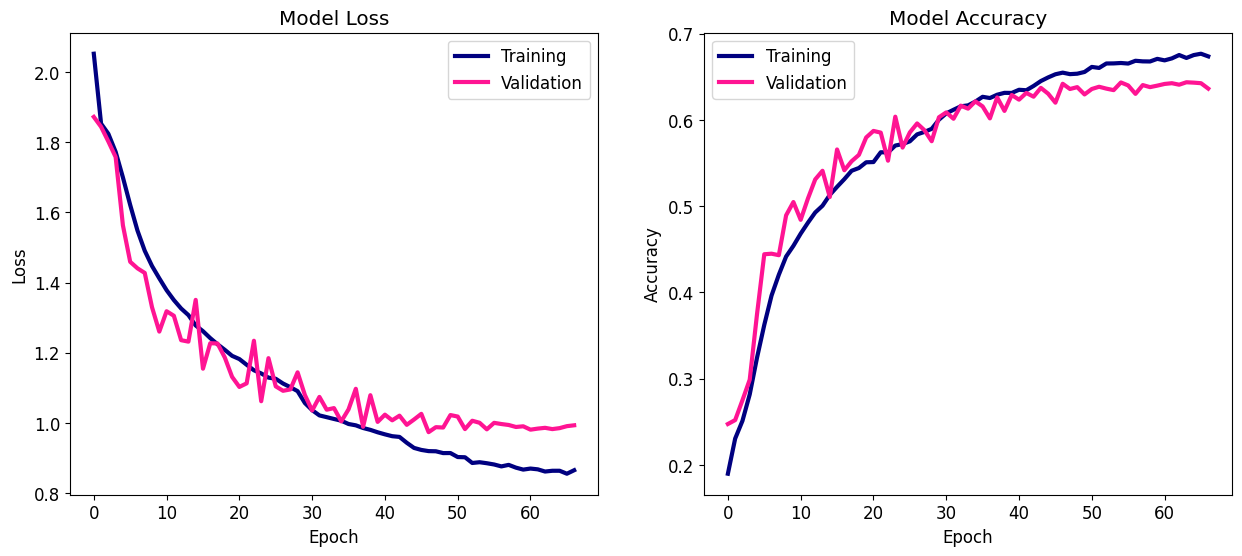

In [30]:
plot_metrics(history)

In [31]:
model.load_weights(model.checkpoint_path)
evaluate_class(model, x_test, y_test)

Emotion        Accuracy
-----------------------
angry          59.2%
disgust        69.9%
fear           35.7%
happy          82.2%
neutral        72.5%
sad            45.0%
surprise       80.6%
-----------------------
Overall        63.9%


In [ ]:
%cp /content/project/run/vggnet.h5 /content/gdrive/MyDrive/loopQ/project/saved_models